Attempt to add in normal images which would previously have been excluded so that the model can take a complete scan as input. First we'll just create a tfrecords containing these new images to see if shuffle_batch will mix them in properly. If not we'll recreate the entire dataset with those images mixed in.

It seems that it is sufficient to create another tfrecords file containing only these extra images, tf.train.shuffle_batch will shuffle rows from all tfrecords files, so we are just creating one extra file and will include it when retraining our models.

However, we still need to add some of these new images to the test and cv datasets

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from mammo_utils import random_flip_image
import os
%matplotlib inline

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load extra ddsm images
dba_images = np.load(os.path.join("data", "dba_slices10.npy"))
dba_labels = np.load(os.path.join("data", "dba_labels10.npy"))

howtek_images = np.load(os.path.join("data", "howtek_slices10.npy"))
howtek_labels = np.load(os.path.join("data", "howtek_labels10.npy"))

lumisys_images = np.load(os.path.join("data", "lumisys_slices10.npy"))
lumisys_labels = np.load(os.path.join("data", "lumisys_labels10.npy"))

In [3]:
# combine them and delete old variables
normal_images = np.concatenate([dba_images, howtek_images, lumisys_images], axis=0)
normal_labels = np.concatenate([dba_labels, howtek_labels, lumisys_labels], axis=0)

del(dba_images, howtek_images, lumisys_images)
del(dba_labels, howtek_labels, lumisys_labels)

In [4]:
print("Normal Images:", normal_images.shape)
print("Normal Labels:", normal_labels.shape)

Normal Images: (38396, 299, 299, 1)
Normal Labels: (38396,)


In [6]:
# shuffle the data
normal_images, normal_labels = shuffle(normal_images, normal_labels, random_state=3871)

In [7]:
# take a subset of the images to add to the data set
extra_train_images = normal_images[:9000,:,:,:]

# create the encoded labels
extra_train_labels = np.zeros(len(extra_train_images))

print("Extra Train Images:", extra_train_images.shape)
print("Extra Train Labels:", extra_train_labels.shape)

Extra Train Images: (9000, 299, 299, 1)
Extra Train Labels: (9000,)


In [8]:
# separate some more images to add to the test and validation datasets
extra_test_images = normal_images[10000:12400,:,:,:]
extra_test_labels = np.zeros(len(extra_test_images))

print("Extra Test Images:", extra_test_images.shape)
print("Extra Test Labels:", extra_test_labels.shape)

Extra Test Images: (2400, 299, 299, 1)
Extra Test Labels: (2400,)


In [8]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [11]:
# write train data to tfrecords in 1 batches
import math
num_batches = 1
batch_size = math.ceil(extra_train_images.shape[0] / num_batches)

for i in range(num_batches):
    train_path = os.path.join("data","training9.5_" + str(i) + '.tfrecords')
    writer = tf.python_io.TFRecordWriter(train_path)
    start_row = i * batch_size
    end_row = start_row + batch_size - 1
                              
    for idx in range(start_row, end_row):
        # try to get the data, if there is an error skip this index
        try:
            label = 0
            label_normal = 0
            image = extra_train_images[idx]
            image_raw = image.tostring()
        except:
            continue
            
        example = tf.train.Example(
            features=tf.train.Features(
              feature={
                # A Feature contains one of either a int64_list,
                # float_list, or bytes_list
                'label': _int64_feature(label),
                'label_normal': _int64_feature(label_normal),
                'image': _bytes_feature(image_raw),
              }))

        # use the proto object to serialize the example to a string
        serialized = example.SerializeToString()
        # write the serialized object to disk
        writer.write(serialized)

## Verify that the data was written correctly

In [2]:
# make sure everything was written properly by reading it back out
def read_and_decode_single_example(filenames):
    filename_queue = tf.train.string_input_producer(filenames, num_epochs=1)
    
    reader = tf.TFRecordReader()
    
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([], tf.string)
        })
    
    # now return the converted data
    label = features['label']
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, [299, 299, 1])
    
    # scale the image
    #image = tf.image.per_image_standardization(image)
    
    # random flip image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    image = tf.cast(image, tf.float32)
    
    #image = tf.image.random_brightness(image, max_delta=10)
    #image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    
    image = standardize(image)
    
    return label, image

def standardize(tensor):
#     mean, variance = tf.nn.moments(tensor, axes=[0], name="moments")

#     sigma = tf.sqrt(variance, name="sigma")
#     adj_sigma = tf.maximum(sigma, 0.0033)

#     standardized_tensor = tf.divide(tf.subtract(tensor, mean), adj_sigma)
    
    standardized_tensor = tf.divide(
        tf.subtract(
            tensor,
            tf.reduce_min(tensor, axis=0)
        ),
        tf.subtract(
            tf.reduce_max(tensor, axis=0),
            tf.reduce_min(tensor, axis=0)
        )
    )
    
    return standardized_tensor

In [4]:
label, image = read_and_decode_single_example(["data/training9_0.tfrecords", "data/training9_1.tfrecords", "data/training9.5_0.tfrecords", "data/training9_2.tfrecords", "data/training9_3.tfrecords"])

#images_batch, labels_batch = tf.train.shuffle_batch([image, label], batch_size=16, capacity=2000, min_after_dequeue=1000)
images_batch, labels_batch = tf.train.batch([image, label], batch_size=16, capacity=2000)

contrast_img = tf.image.adjust_contrast(images_batch, 1.5)

global_step = tf.Variable(0, trainable=False)

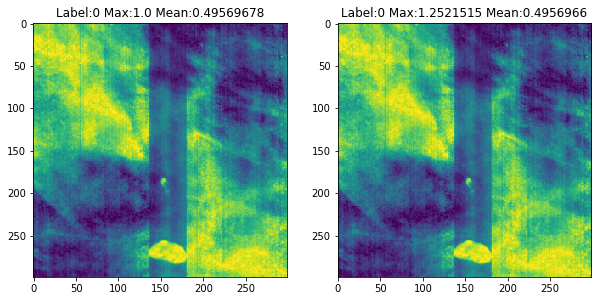

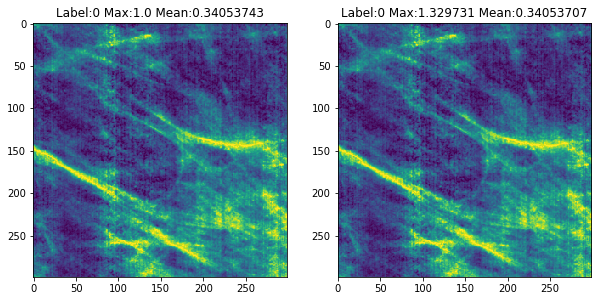

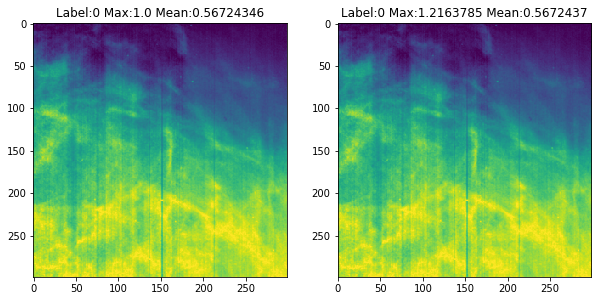

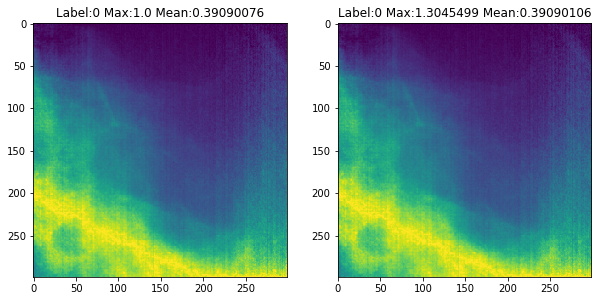

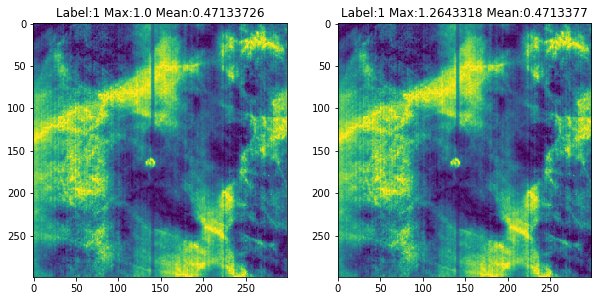

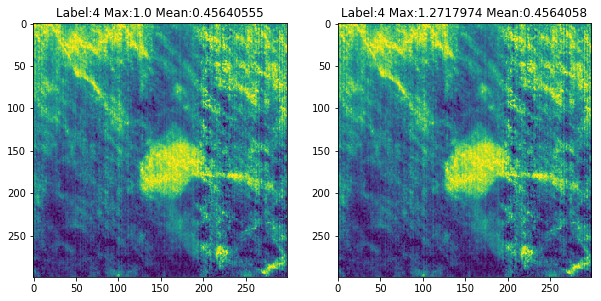

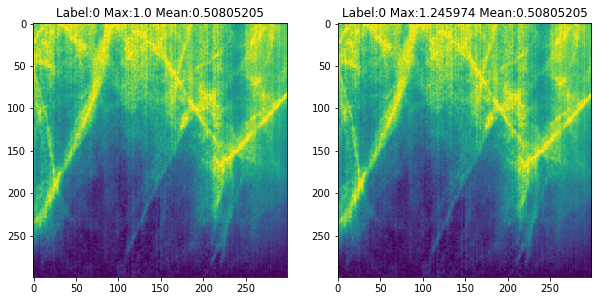

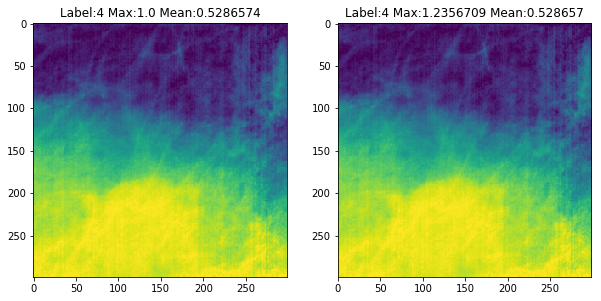

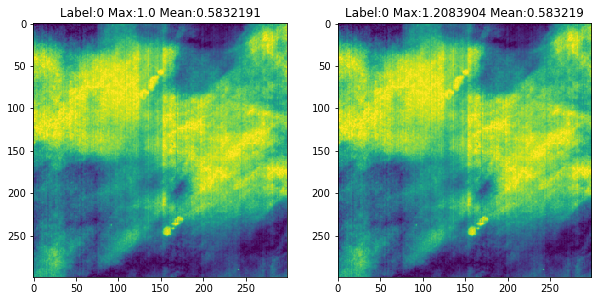

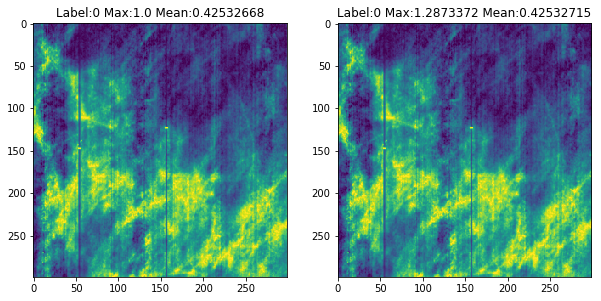

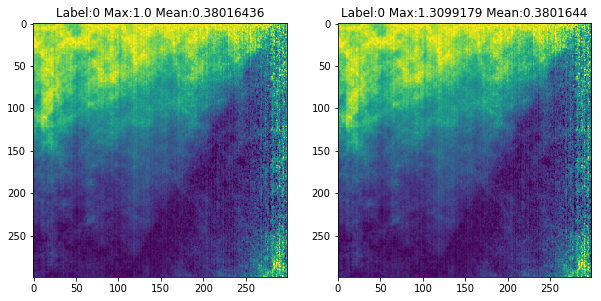

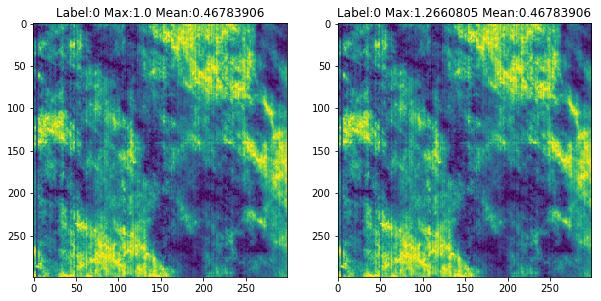

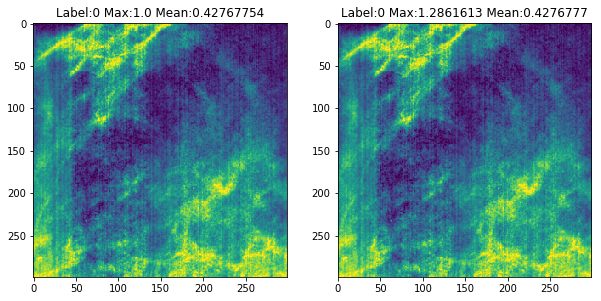

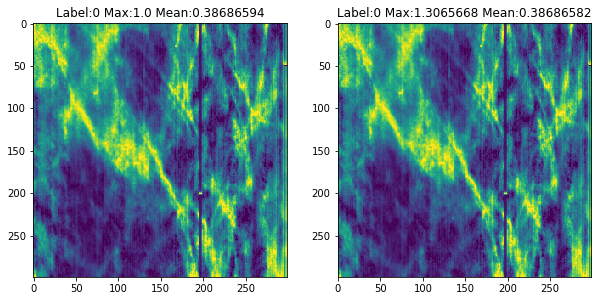

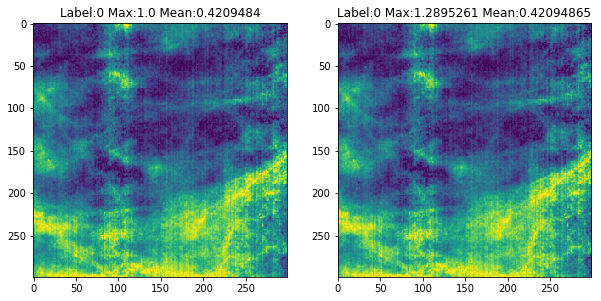

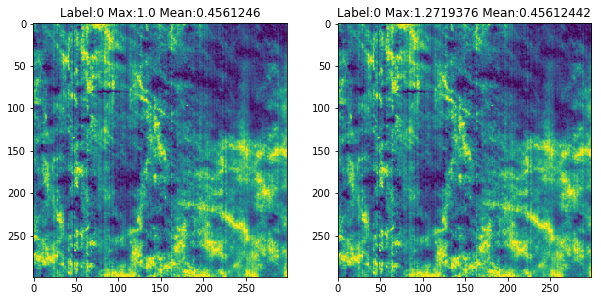

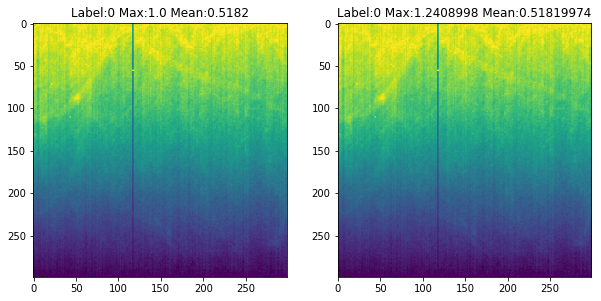

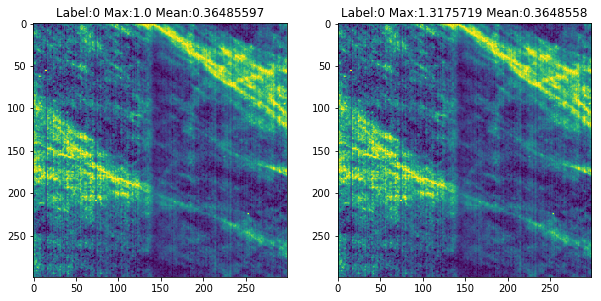

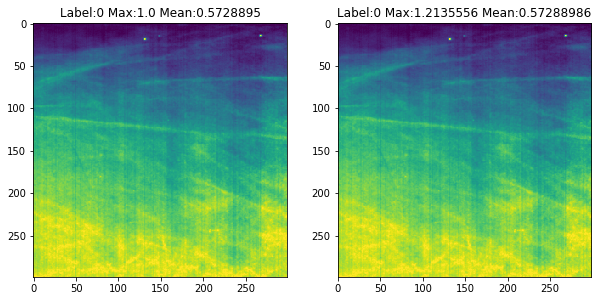

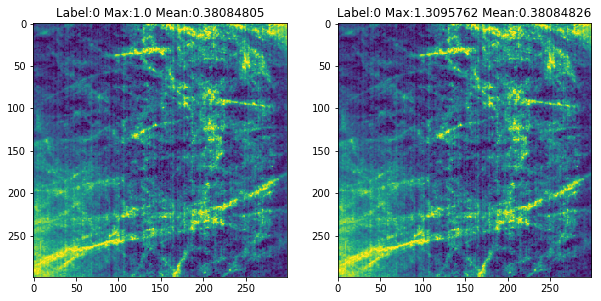

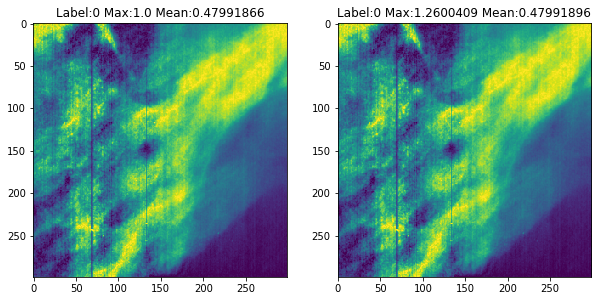

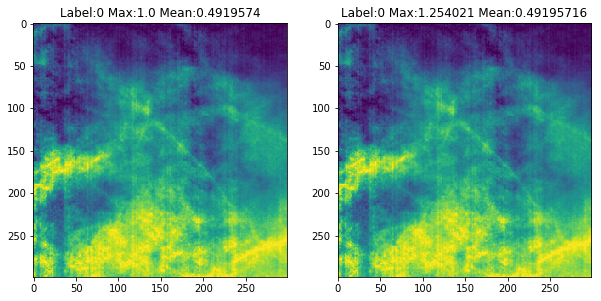

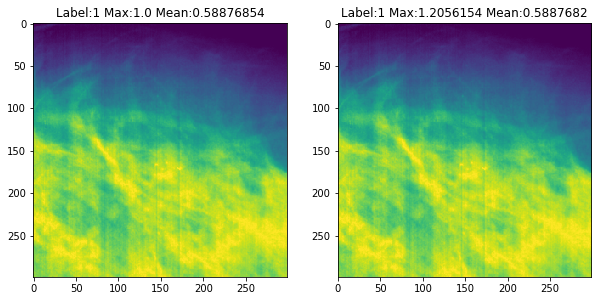

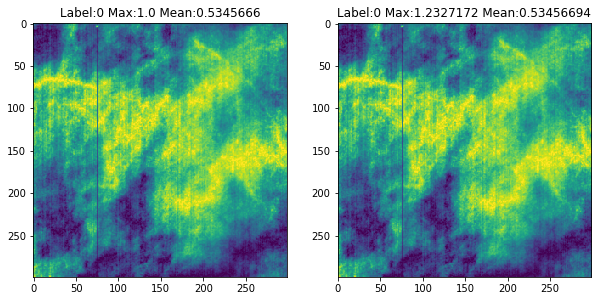

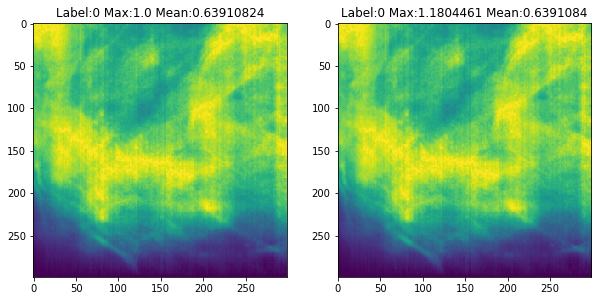

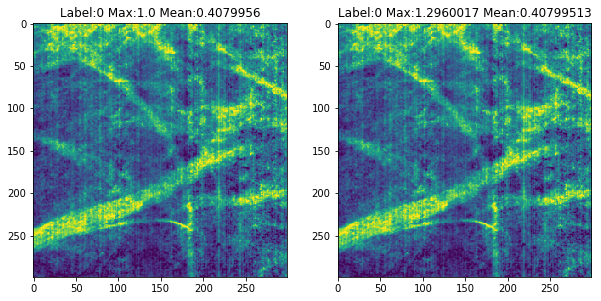

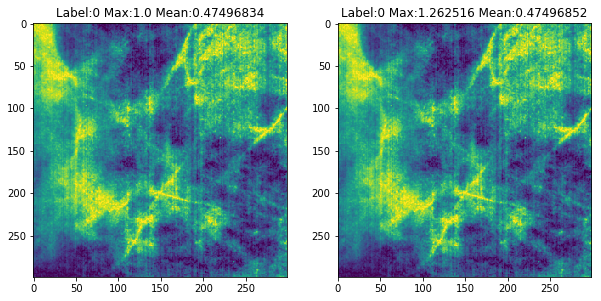

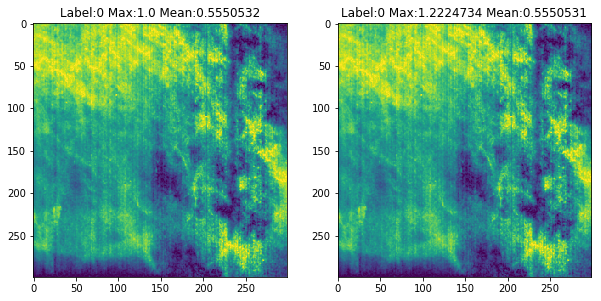

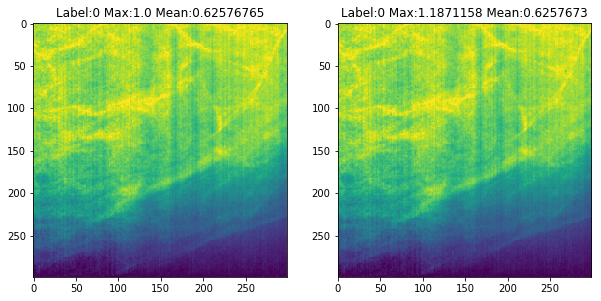

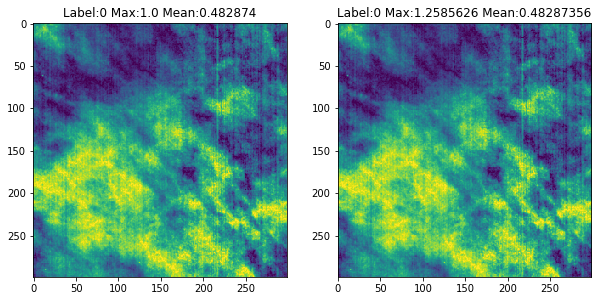

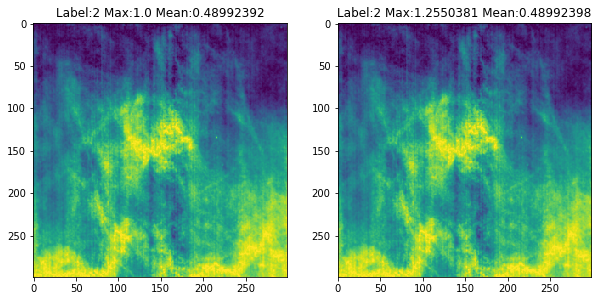

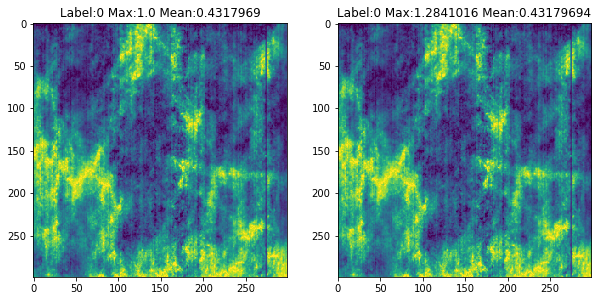

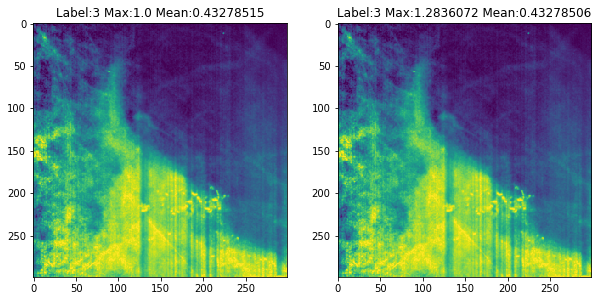

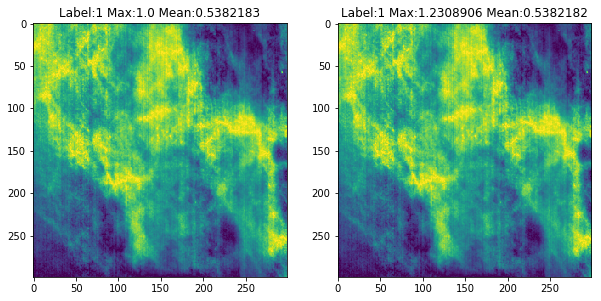

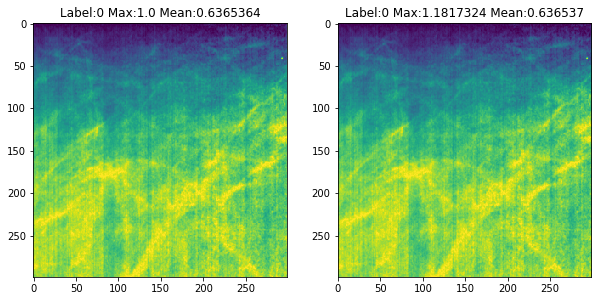

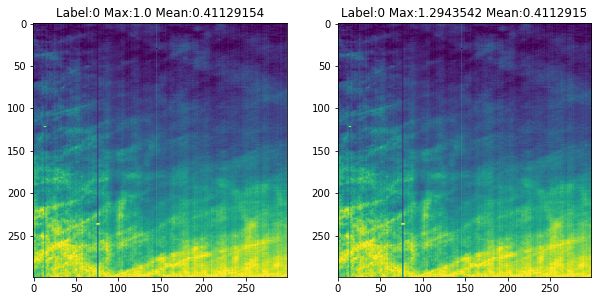

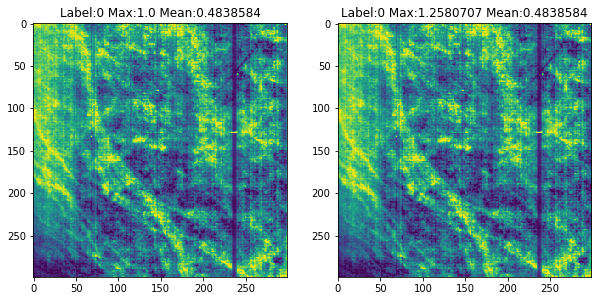

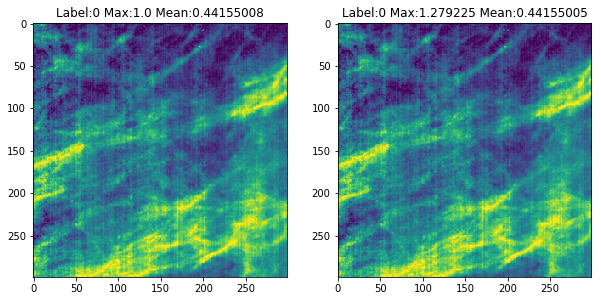

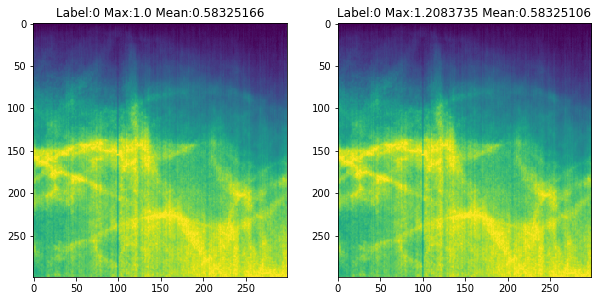

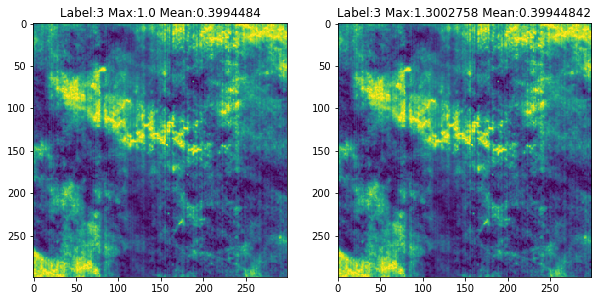

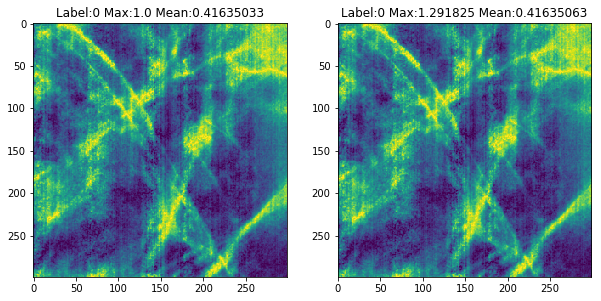

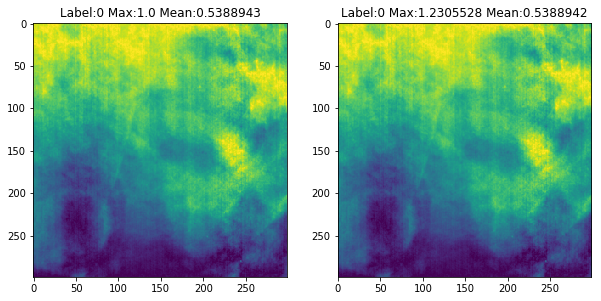

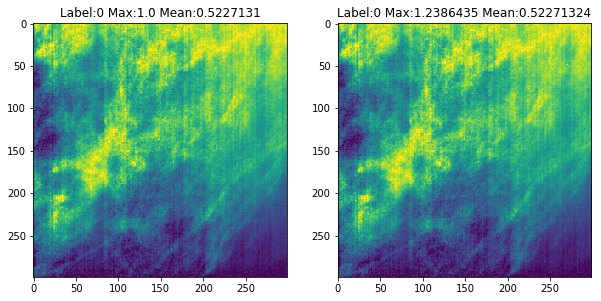

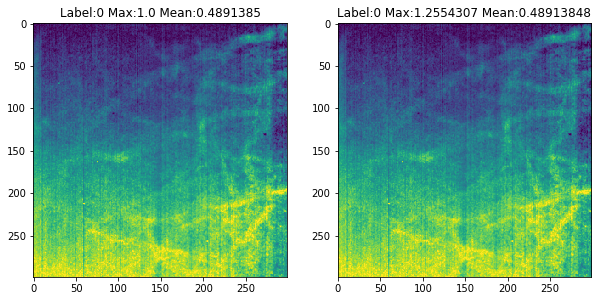

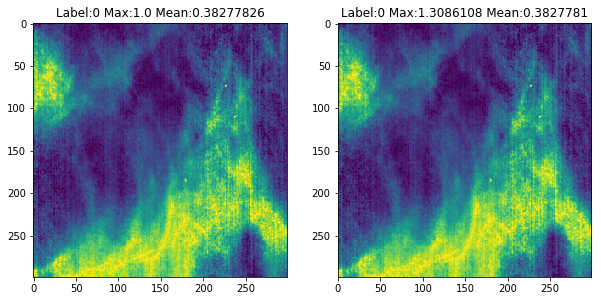

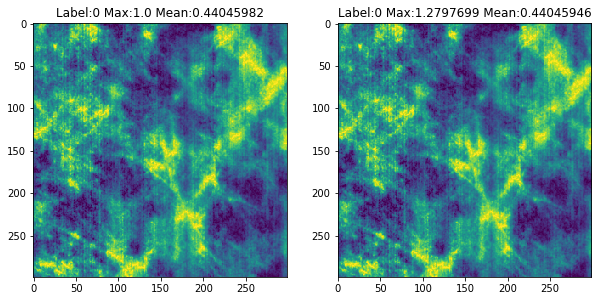

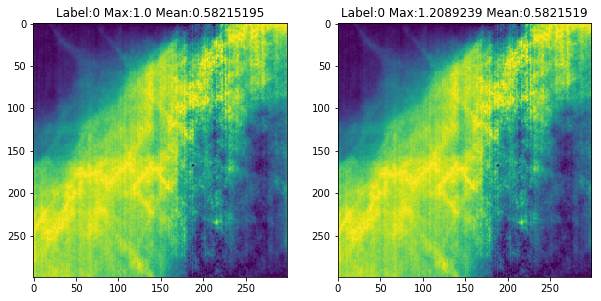

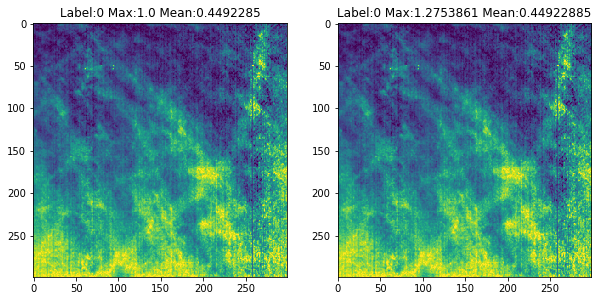

In [5]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for j in range(3):
        la_b, im_b, im_b2 = sess.run([labels_batch, images_batch, contrast_img])
        
        for i in range(16):
            f, ax = plt.subplots(1, 2, figsize=(10, 5))
            
            ax[0].imshow(im_b[i].reshape([299,299]))
            ax[0].set_title("Label:" + str(la_b[i]) + " Max:" + str(np.max(im_b[i])) + " Mean:" + str(np.mean(im_b[i])))
            
            ax[1].imshow(im_b2[i].reshape([299,299]))
            ax[1].set_title("Label:" + str(la_b[i]) + " Max:" + str(np.max(im_b2[i])) + " Mean:" + str(np.mean(im_b2[i])))
            plt.show()
            
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)

## Add to Test and CV Datasets

Now that we have established that we don't need to recreate the entire dataset we do need to add 1,200 of our new images to each of our test and validation datasets. Rather than recreate them from scratch we'll just load the existing datasets and add the new images to them.

In [12]:
# first shuffle the extra test images and split them
from sklearn.model_selection import train_test_split

# now shuffle and split the normal images 
X_cv, X_te, y_cv, y_te  = train_test_split(extra_test_images, extra_test_labels, test_size=0.5, random_state=3455)

print("X_cv:", X_cv.shape)
print("y_cv:", y_cv.shape)
print("X_te:", X_te.shape)
print("y_te:", y_te.shape)

X_cv: (1200, 299, 299, 1)
y_cv: (1200,)
X_te: (1200, 299, 299, 1)
y_te: (1200,)


In [13]:
# load our existing test and cv data
test_data = np.load(os.path.join("data", "test9_data.npy"))
test_labels = np.load(os.path.join("data", "test9_labels.npy"))

cv_data = np.load(os.path.join("data", "cv9_data.npy"))
cv_labels = np.load(os.path.join("data", "cv9_labels.npy"))

In [14]:
# add our new records in, reshuffle and save them
new_test_data = np.concatenate([test_data, X_te], axis=0)
new_test_labels = np.concatenate([test_labels, y_te], axis=0)

new_test_data, new_test_labels = shuffle(new_test_data, new_test_labels, random_state=1234)

# save the data
np.save(os.path.join("data", "test9.5_data.npy"), new_test_data)
np.save(os.path.join("data", "test9.5_labels.npy"), new_test_labels)

In [15]:
# do the same for the cv data
new_cv_data = np.concatenate([cv_data, X_cv], axis=0)
new_cv_labels = np.concatenate([cv_labels, y_cv], axis=0)

new_cv_data, new_cv_labels = shuffle(new_cv_data, new_cv_labels, random_state=1234)

# save the data
np.save(os.path.join("data", "cv9.5_data.npy"), new_cv_data)
np.save(os.path.join("data", "cv9.5_labels.npy"), new_cv_labels)

In [16]:
# find the new distribution of the labels
pd.value_counts(new_cv_labels, normalize=True)

0.0    0.861065
1.0    0.077371
3.0    0.051165
4.0    0.005408
2.0    0.004992
dtype: float64